In [17]:
from IPython.display import display, HTML

# Specify the path to your image file
image_path = 'documents/pefile2.png'

# Display the image with center alignment
display(HTML(f'<div style="text-align:center;"><img src="{image_path}" /></div>'))

In [1]:
import os
import pandas
import numpy
import pickle
import pefile
import sklearn.ensemble as ek
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn import svm
import sklearn.metrics as metrics

In [2]:
import pandas as pd
dataset = pd.read_csv('data.csv', sep='|')

In [2]:
dataset.head()

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,memtest.exe,631ea355665f28d4707448e442fbf5b8,332,224,258,9,0,361984,115712,0,...,4,3.262823,2.568844,3.537939,8797.000000,216,18032,0,16,1
1,ose.exe,9d10f99a6712e28f8acd5641e3a7ea6b,332,224,3330,9,0,130560,19968,0,...,2,4.250461,3.420744,5.080177,837.000000,518,1156,72,18,1
2,setup.exe,4d92f518527353c0db88a70fddcfd390,332,224,3330,9,0,517120,621568,0,...,11,4.426324,2.846449,5.271813,31102.272727,104,270376,72,18,1
3,DW20.EXE,a41e524f8d45f0074fd07805ff0c9b12,332,224,258,9,0,585728,369152,0,...,10,4.364291,2.669314,6.400720,1457.000000,90,4264,72,18,1
4,dwtrig20.exe,c87e561258f2f8650cef999bf643a731,332,224,258,9,0,294912,247296,0,...,2,4.306100,3.421598,5.190603,1074.500000,849,1300,72,18,1


In [3]:
dataset.columns    # name of the columns

Index(['Name', 'md5', 'Machine', 'SizeOfOptionalHeader', 'Characteristics',
       'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode',
       'SizeOfInitializedData', 'SizeOfUninitializedData',
       'AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'ImageBase',
       'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion',
       'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion',
       'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfImage',
       'SizeOfHeaders', 'CheckSum', 'Subsystem', 'DllCharacteristics',
       'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve',
       'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes', 'SectionsNb',
       'SectionsMeanEntropy', 'SectionsMinEntropy', 'SectionsMaxEntropy',
       'SectionsMeanRawsize', 'SectionsMinRawsize', 'SectionMaxRawsize',
       'SectionsMeanVirtualsize', 'SectionsMinVirtualsize',
       'SectionMaxVirtualsize', 'ImportsNbDLL', 'ImportsNb',
       'Impor

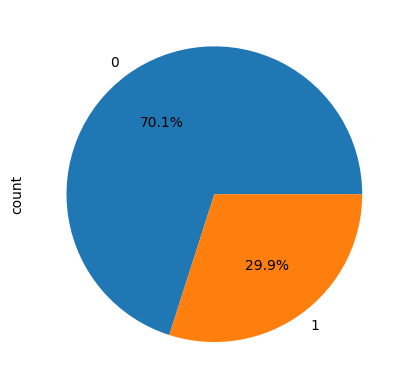

In [19]:
import matplotlib.pyplot as plt

dataset["legitimate"].value_counts().plot(kind="pie",autopct="%1.1f%%")
plt.show()

In [5]:
## we see that there is not null values
print(dataset.isnull().sum())

Name                           0
md5                            0
Machine                        0
SizeOfOptionalHeader           0
Characteristics                0
MajorLinkerVersion             0
MinorLinkerVersion             0
SizeOfCode                     0
SizeOfInitializedData          0
SizeOfUninitializedData        0
AddressOfEntryPoint            0
BaseOfCode                     0
BaseOfData                     0
ImageBase                      0
SectionAlignment               0
FileAlignment                  0
MajorOperatingSystemVersion    0
MinorOperatingSystemVersion    0
MajorImageVersion              0
MinorImageVersion              0
MajorSubsystemVersion          0
MinorSubsystemVersion          0
SizeOfImage                    0
SizeOfHeaders                  0
CheckSum                       0
Subsystem                      0
DllCharacteristics             0
SizeOfStackReserve             0
SizeOfStackCommit              0
SizeOfHeapReserve              0
SizeOfHeap

In [20]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

def summarize_feature_counts(legit_dataset, malware_dataset, feature_column):
    legit_counts = legit_dataset[feature_column].value_counts()
    malware_counts = malware_dataset[feature_column].value_counts()

    print("Legitimate Dataset -", feature_column)
    print(legit_counts)
    print("\nMalware Dataset -", feature_column)
    print(malware_counts)

legit = dataset[0:41323].drop(['legitimate'], axis=1)
malware = dataset[41323::].drop(['legitimate'], axis=1)

In [21]:
print(dataset[0:41323]['legitimate'].value_counts())
print(dataset[41323::]['legitimate'].value_counts())

legitimate
1    41323
Name: count, dtype: int64
legitimate
0    96724
Name: count, dtype: int64


In [22]:
summarize_feature_counts(legit, malware, 'CheckSum')

Legitimate Dataset - CheckSum
CheckSum
0         1883
65660        9
223642       7
72474        4
56038        4
          ... 
135664       1
189098       1
507934       1
680293       1
121734       1
Name: count, Length: 37955, dtype: int64

Malware Dataset - CheckSum
CheckSum
0             16854
2018161488      895
345524          536
301854          488
213271          482
              ...  
509331            1
380671            1
578124            1
525293            1
1360499877        1
Name: count, Length: 44342, dtype: int64


In [8]:
all_results = [] # the list contains different results from different models for comparison purposes

In [3]:
data = dataset.drop(['Name', 'md5', 'legitimate'], axis = 1).values
target = dataset['legitimate'].values

# Feature Selection - with ExtraTreesClassifier

In [4]:
extratrees = ek.ExtraTreesClassifier().fit(data, target)
model = SelectFromModel(extratrees, prefit=True)
X_new = model.transform(data)
nbfeatures = X_new.shape[1]
print("number of selected features is %s" % nbfeatures)

number of selected features is 14


In [5]:
from sklearn.model_selection import train_test_split

#splitting the data (70% - training and 30% - testing)
X_train_ExtraTreesClassifier, X_test_ExtraTreesClassifier, y_train_ExtraTreesClassifier, y_test_ExtraTreesClassifier = train_test_split(X_new, target, test_size = 0.29)

# Without feature selection

In [6]:
#splitting the data (70% - training and 30% - testing)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.29)

# Feature Selection - with SVC

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

svc = SVC(kernel="linear")
selector = RFE(estimator=svc, n_features_to_select=nbfeatures, step=1)
selector = selector.fit(data, target)
X_new_svc = selector.transform(data)
nbfeatures = X_new_svc.shape[1]

print("Number of selected features is %s" % nbfeatures)

In [ ]:
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_new_svc, target, test_size = 0.29)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def classify(X_train, X_test, y_train, y_test, name):
    # Train a classification model. in the article they used 10 trees
    clf = RandomForestClassifier(n_estimators=10)
    clf.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = clf.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred, pos_label=0)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Store results in a tuple
    RF_results = [accuracy, precision, recall, f1]
    RF_tuple = ("mode - " + name, RF_results)

    all_results.append(RF_tuple)
    
    # Print evaluation metrics
    print('Accuracy (%s): %s' % (name, RF_results[0]))
    print('Precision (%s): %s' % (name, RF_results[1]))
    print('Recall (%s): %s' % (name, RF_results[2]))
    print('F1 score (%s): %s' % (name, RF_results[3]))

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Extract TP, TN, FP, FN from confusion matrix
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    
    # Display the confusion matrix with counts
    print("Confusion Matrix:")
    print(conf_matrix)

    return clf

# classify(X_train, X_test, y_train, y_test, "RandomForest - regular")
clf = classify(X_train_ExtraTreesClassifier, X_test_ExtraTreesClassifier, y_train_ExtraTreesClassifier, y_test_ExtraTreesClassifier, "RandomForest - ExtraTreesClassifier")

Accuracy (RandomForest - ExtraTreesClassifier): 0.9930059449467952
Precision (RandomForest - ExtraTreesClassifier): 0.9956202820111095
Recall (RandomForest - ExtraTreesClassifier): 0.9944163880788107
F1 score (RandomForest - ExtraTreesClassifier): 0.9950179708907156
Confusion Matrix:
[[27961   157]
 [  123 11793]]


In [23]:
joblib.dump(clf,'Classifier/classifier.pkl')

['Classifier/classifier.pkl']

# saving the features for extraction later

In [10]:
features = []

# top nbfeatures
index = numpy.argsort(extratrees.feature_importances_)[::-1][:nbfeatures]

for f in range(nbfeatures):
    print("%d. feature %s (%f)" % (f + 1, dataset.columns[2+index[f]], extratrees.feature_importances_[index[f]]))
    features.append(dataset.columns[2+f])

# Save the features to a pickle file
with open('Classifier/features.pkl', 'wb') as f:
    pickle.dump(features, f)
    
print(features)

1. feature DllCharacteristics (0.155439)
2. feature Characteristics (0.107305)
3. feature Machine (0.090189)
4. feature Subsystem (0.079206)
5. feature VersionInformationSize (0.064292)
6. feature SectionsMaxEntropy (0.056659)
7. feature MajorSubsystemVersion (0.054068)
8. feature ImageBase (0.046271)
9. feature SizeOfOptionalHeader (0.041560)
10. feature ResourcesMinEntropy (0.035825)
11. feature SizeOfStackReserve (0.028565)
12. feature MajorOperatingSystemVersion (0.025421)
13. feature ResourcesMaxEntropy (0.024042)
14. feature SectionsMeanEntropy (0.019337)
['Machine', 'SizeOfOptionalHeader', 'Characteristics', 'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'ImageBase', 'SectionAlignment', 'FileAlignment']
